<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session8/EVA4S8_main_attempt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempt-2 - Solution
1. resnet18 model
2. calculate mean and std for the entire dataset and apply data normalization
3. Image augmentation: horizontal flip, croping
4. L1 and L2 regularization is applied. 

# Check for current directory and necessary files availability

In [0]:
# check current directory
!pwd

/content


In [0]:
# change to working directory
cd 'session8'

/content/session8


In [0]:
# verify if all necessary files are avaiabale in current directory for loading
!ls

cifar10_net_cnn.py  model_history.py  plot_utils.py	 resnet.py
data_utils.py	    model_utils.py    regularization.py


# Load standard and custom python packages

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR

# load custom python packages
import data_utils as dutils       # utilities for dataset, transform, dataloaders
import model_utils as mutils      # utilities for basic conv block, depthwise seperable blocks, train, test, build fucntions
import model_history as mhistory  # utilitie for storing and visualizing model results
import plot_utils as putils       # utilities for ploting images, model history, misclassified images etc
import regularization             # L1 loss fxn
import cifar10_net_cnn            # CIFAR10 network design using custom CNN network
import resnet                     # resnet model

%matplotlib inline

# Check GPU avaiability
use cuda and get device with GPU

In [0]:
# check GPU availability and use cuda to get GPU device
device = dutils.get_device()

CUDA Available?3 True
cuda:0


# Basis configurations for CIFAR10

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1
batch_size=128

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# Data Preprocessing and Loading of  CIFAR10 dataset
1. first calculate the mean and std for the entire dataset. this will be used for dataset normalization during data transform
2. define data transforms-image augmentation, toSensor, normalization etc
3. load the dataset using data loader

In [0]:
from torchvision import transforms

# fucntion that define data transform as per image processing needs for the solution
def get_data_transform(means, stds):
    # Train Phase transformations
    normalize = transforms.Normalize(means, stds)
    #normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # mean and std
    #normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean and std

    # resize = transforms.Resize((28, 28))

    train_transforms = transforms.Compose([
                                          #resize,
                                          #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                          #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                          transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          normalize, 
                                          #transforms.RandomErasing(scale=(0.02, 0.20), ratio=(0.8, 1.2))
                                          ])

    # Test Phase transformations
    test_transforms = transforms.Compose([
                                          #resize,
                                          transforms.ToTensor(),
                                          normalize
                                          ])
    
    return train_transforms, test_transforms

In [0]:
# first calculate dataset mean, std to be used for normalizing dataset
means, stds = dutils.calculate_dataset_mean_std()
print("means: {}".format(means))
print("stds: {}".format(stds))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Total dataset(train+test) shape:  (60000, 32, 32, 3)
means: (0.49186864, 0.48265335, 0.44717798)
stds: (0.24697131, 0.24338901, 0.26159254)


In [0]:
# data transform
train_transforms, test_transforms = get_data_transform(means, stds)

# load data
train_loader, test_loader = dutils.get_dataloader(train_transforms, test_transforms, batch_size=batch_size, num_workers=4)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


# Visualize few training dataset and aurmented images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

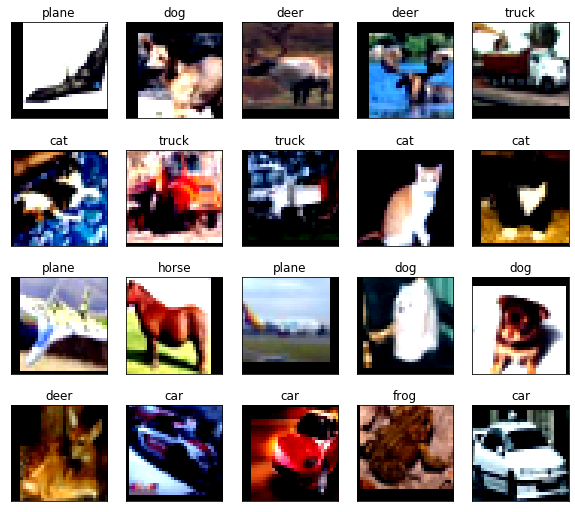

In [0]:
# visualize few training dataset images
putils.plot_dataset_images(device, classes, train_loader)

# Create Resnet18 based CIFAR10 Network

In [0]:
# Create CIFAR10 network
model = resnet.ResNet18()
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Build and train model

In [0]:
model_name = "CIFAR10 Resnet18"
model =  model.to(device)
EPOCHS = 40

#criterion = F.nll_loss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)  # using L2 Regulaization


lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
#lr_scheduler = MultiStepLR(optimizer, milestones=[4,8,12,16,20], gamma=0.3)
#lr_lambda = lambda epoch: 0.1/(1+1.2*(epoch-(epoch%3)))
#lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

model_history = mutils.build_model(model, 
                            device, 
                            trainloader=train_loader, 
                            testloader=test_loader, 
                            epochs=EPOCHS,
                            criterion=criterion, 
                            optimizer=optimizer,
                            lr_scheduler=lr_scheduler,
                            L1_loss_enable=True)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH-1: learning rate is: 0.01


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.502692, Accuracy: 5205/10000 (52.05%)

EPOCH-2: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.805015, Accuracy: 7299/10000 (72.99%)

EPOCH-3: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.787551, Accuracy: 7321/10000 (73.21%)

EPOCH-4: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.580586, Accuracy: 8008/10000 (80.08%)

EPOCH-5: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.548926, Accuracy: 8178/10000 (81.78%)

EPOCH-6: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.651467, Accuracy: 7846/10000 (78.46%)

EPOCH-7: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.499239, Accuracy: 8344/10000 (83.44%)

EPOCH-8: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.492135, Accuracy: 8370/10000 (83.70%)

EPOCH-9: learning rate is: 0.001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.327688, Accuracy: 8890/10000 (88.90%)

EPOCH-10: learning rate is: 0.001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.319946, Accuracy: 8928/10000 (89.28%)

EPOCH-11: learning rate is: 0.001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.319676, Accuracy: 8946/10000 (89.46%)

EPOCH-12: learning rate is: 0.001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.310592, Accuracy: 8961/10000 (89.61%)

EPOCH-13: learning rate is: 0.001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.312862, Accuracy: 8971/10000 (89.71%)

EPOCH-14: learning rate is: 0.001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.313774, Accuracy: 8964/10000 (89.64%)

EPOCH-15: learning rate is: 0.001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.317912, Accuracy: 8966/10000 (89.66%)

EPOCH-16: learning rate is: 0.001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.312047, Accuracy: 8986/10000 (89.86%)

EPOCH-17: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.295214, Accuracy: 9027/10000 (90.27%)

EPOCH-18: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.292374, Accuracy: 9040/10000 (90.40%)

EPOCH-19: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.291144, Accuracy: 9042/10000 (90.42%)

EPOCH-20: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.294022, Accuracy: 9042/10000 (90.42%)

EPOCH-21: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.293920, Accuracy: 9045/10000 (90.45%)

EPOCH-22: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.296389, Accuracy: 9050/10000 (90.50%)

EPOCH-23: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.296827, Accuracy: 9056/10000 (90.56%)

EPOCH-24: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.296408, Accuracy: 9043/10000 (90.43%)

EPOCH-25: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.298397, Accuracy: 9047/10000 (90.47%)

EPOCH-26: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.298696, Accuracy: 9043/10000 (90.43%)

EPOCH-27: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.295674, Accuracy: 9049/10000 (90.49%)

EPOCH-28: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.301276, Accuracy: 9053/10000 (90.53%)

EPOCH-29: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.295059, Accuracy: 9052/10000 (90.52%)

EPOCH-30: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.293916, Accuracy: 9043/10000 (90.43%)

EPOCH-31: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.295159, Accuracy: 9053/10000 (90.53%)

EPOCH-32: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.295773, Accuracy: 9060/10000 (90.60%)

EPOCH-33: learning rate is: 1.0000000000000002e-06


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.291722, Accuracy: 9048/10000 (90.48%)

EPOCH-34: learning rate is: 1.0000000000000002e-06


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.294924, Accuracy: 9053/10000 (90.53%)

EPOCH-35: learning rate is: 1.0000000000000002e-06


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.292087, Accuracy: 9058/10000 (90.58%)

EPOCH-36: learning rate is: 1.0000000000000002e-06


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.292391, Accuracy: 9063/10000 (90.63%)

EPOCH-37: learning rate is: 1.0000000000000002e-06


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.294632, Accuracy: 9051/10000 (90.51%)

EPOCH-38: learning rate is: 1.0000000000000002e-06


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.305726, Accuracy: 9053/10000 (90.53%)

EPOCH-39: learning rate is: 1.0000000000000002e-06


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.300261, Accuracy: 9051/10000 (90.51%)

EPOCH-40: learning rate is: 1.0000000000000002e-06


Loss=0.431640 Batch_id=391 Accuracy=95.04: 100%|██████████| 391/391 [03:10<00:00,  2.56it/s]



Test set: Average loss: 0.297970, Accuracy: 9053/10000 (90.53%)



# Analyse the train and test best result and calculate test accuracy for each classes

In [0]:
# model result summary
model_history.result_summary()

Training best result: Accuracy: 95.11 at Epoch 37
Testing  best result: Accuracy: 90.63 at Epoch 36
Acuracy Gap: 4.48


In [0]:
# get class based test accuracy for the network
mutils.class_based_accuracy(model, device, classes, test_loader)

Accuracy of plane : 96 %
Accuracy of   car : 96 %
Accuracy of  bird : 73 %
Accuracy of   cat : 87 %
Accuracy of  deer : 93 %
Accuracy of   dog : 75 %
Accuracy of  frog : 92 %
Accuracy of horse : 93 %
Accuracy of  ship : 100 %
Accuracy of truck : 97 %


# Visualize model history and network convergence

Visulaizing train and test result history

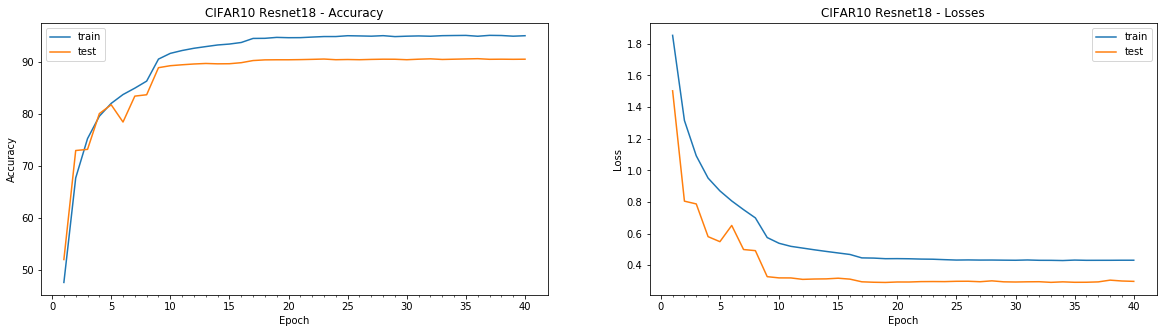

In [0]:
# Accurracy and loss history plot
model_history.plot_history(title=model_name, save_filename="model_history")

Learning rate plot

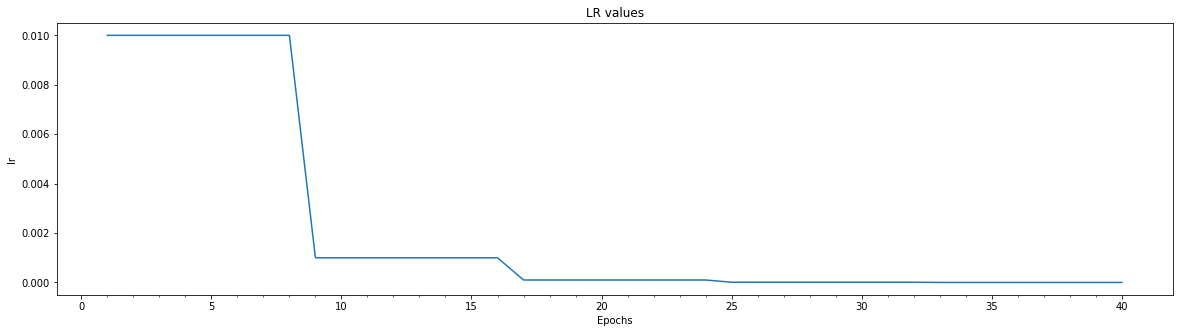

In [0]:
# Note: seriesname="val_acc", "val_loss", "train_acc", "train_loss", "lr"
model_history.plot_data_against_epoch("LR values", seriesname="lr", save_filename="lr_trend")

Test accuracy vs Leraning rate plot

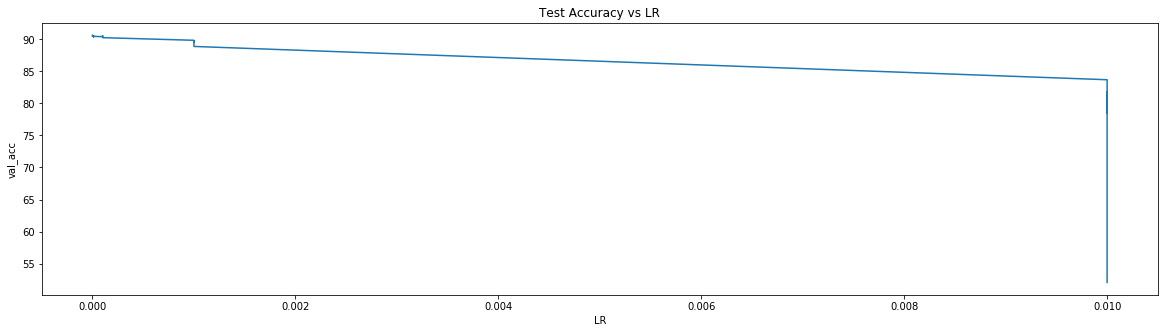

In [0]:
# NotE: seriesname="val_acc", "val_loss", "train_acc", "train_loss"
model_history.plot_data_against_lr("Test Accuracy vs LR", seriesname="val_acc", save_filename="test_acc_vs_lr")

Visualize few misclassified images and get an understanding on for what set of unseen data model is not performing good 


Ploting misclassified images: CIFAR10 Resnet18



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

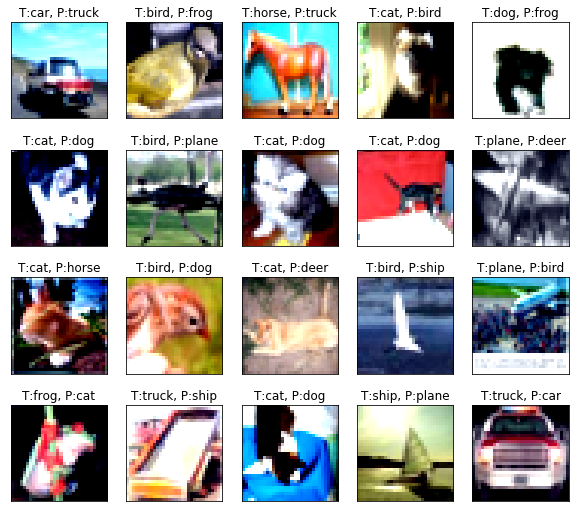

In [0]:
print("\nPloting misclassified images: {}\n".format(model_name))
putils.plot_misclassified_images(model, 
                          device, 
                          classes,
                          testloader=test_loader,
                          save_filename="model_misclassified")